## Домашняя работа по теме "Нейросети в обработке текста"

In [1]:
import numpy as np
import pandas as pd

from string import punctuation
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words

import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

Загрузка датасета

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head(3)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty


In [4]:
df['label'].value_counts() # распределение целевой переменной

0    29720
1     2242
Name: label, dtype: int64

Наблюдается дисбаланс классов, поправим это

In [5]:
# функция балансировки классов: 

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [6]:
# балансировка классов целевой переменной: 

df_for_balancing = df
target_name = 'label'
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

C:\Users\Полина\AppData\Local\Temp\ipykernel_4600\838415103.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sample, ignore_index=True)


0    29720
1    29146
Name: label, dtype: int64

In [7]:
# разобьем на тестовую и тренировачную выборку
df_train, df_val = train_test_split(df_balanced, test_size=0.3, random_state=42) #shuffle=True, stratify=df['label'], )

Загрузим словарь с стоп-словами

In [8]:
stop = set(get_stop_words("en"))

In [9]:
stop

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 "can't",
 'cannot',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 "s

Дополним словарь стоп-слов

In [10]:
new_stop_words = {'im', 'u', 'us', '2', '2016', '4', '2017', 'ive', '3', '1', 'r', 'iam', 's', 'n', '10', 'ur', 'w', '8', '5', 'd', 'shes', '7', 'b', 'ag', 'bc', '6', 'x', '12', 'gt', 'whos', '1st', 'self', '50', 't', 'y'}

stop = stop.union(new_stop_words) 

Загрузим словарь с пунктуацией

In [11]:
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

Теперь избавимся от стоп-слов и пунктуации

In [12]:
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
#     txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in stop]
    return " ".join(txt)

In [13]:
df_train['tweet'].iloc[:1].values # до обработки

array(['now playing  :  oskar schuster - " comatose" on    #melancholy   #melancholymusic'],
      dtype=object)

In [14]:
df_train['tweet'].iloc[:1].apply(preprocess_text).values # после обработки

array(['now playing oskar schuster comatose melancholy melancholymusic'],
      dtype=object)

In [15]:
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 17660/17660 [00:04<00:00, 4215.00it/s]


Проведем токенизацию

In [16]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Полина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['now', 'playing', 'oskar', 'schuster', 'comatose']

In [17]:
tokens_filtered = [word for word in tokens if word.isalnum()]

Создадим словарь с 3000 самыми популярными словами

In [18]:
max_words = 3000
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

2999

Топ 10 популярных слов

In [19]:
tokens_filtered_top[:10]

['user',
 'amp',
 'love',
 'trump',
 'like',
 'day',
 'just',
 'will',
 'libtard',
 'people']

In [33]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

import pprint
pprint.pprint({k: vocabulary[k] for k in list(vocabulary)[:20]})

{'amp': 2,
 'black': 12,
 'can': 16,
 'day': 6,
 'dont': 15,
 'get': 18,
 'happy': 13,
 'just': 7,
 'libtard': 9,
 'like': 5,
 'love': 3,
 'new': 14,
 'people': 10,
 'politics': 19,
 'racist': 20,
 'time': 17,
 'trump': 4,
 'user': 1,
 'white': 11,
 'will': 8}


In [34]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [35]:
max_len = 30

In [36]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

In [37]:
x_train.shape

(41206, 30)

Создадим сеть

In [38]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)

    def forward(self, x):
        output = self.embedding(x) # B, L, E
        #                       B  E  L
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

Обернем в подходящий формат для работы с pyTorch

In [39]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [40]:
batch_size = 512

In [41]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [42]:
val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [43]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 30])
torch.Size([512])
tensor(0)


In [44]:
model = Net(vocab_size=max_words)

In [45]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(3000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 474497


In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [47]:
epochs = 10
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    model.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1]
        test_outputs = model(data[0])

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

    model.train()

print('Training is finished!')

Epoch [1/10]. Step [81/81]. Loss: 0.240. Acc: 0.792. Test loss: 0.149. Test acc: 0.909
Epoch [2/10]. Step [81/81]. Loss: 0.117. Acc: 0.948. Test loss: 0.004. Test acc: 0.964
Epoch [3/10]. Step [81/81]. Loss: 0.042. Acc: 0.985. Test loss: 0.016. Test acc: 0.980
Epoch [4/10]. Step [81/81]. Loss: 0.019. Acc: 0.993. Test loss: 0.006. Test acc: 0.984
Epoch [5/10]. Step [81/81]. Loss: 0.008. Acc: 0.996. Test loss: 0.039. Test acc: 0.987
Epoch [6/10]. Step [81/81]. Loss: 0.018. Acc: 0.997. Test loss: 0.001. Test acc: 0.986
Epoch [7/10]. Step [81/81]. Loss: 0.002. Acc: 0.996. Test loss: 0.000. Test acc: 0.985
Epoch [8/10]. Step [81/81]. Loss: 0.025. Acc: 0.997. Test loss: 0.000. Test acc: 0.981
Epoch [9/10]. Step [81/81]. Loss: 0.013. Acc: 0.996. Test loss: 0.003. Test acc: 0.990
Epoch [10/10]. Step [81/81]. Loss: 0.016. Acc: 0.997. Test loss: 0.000. Test acc: 0.987
Training is finished!


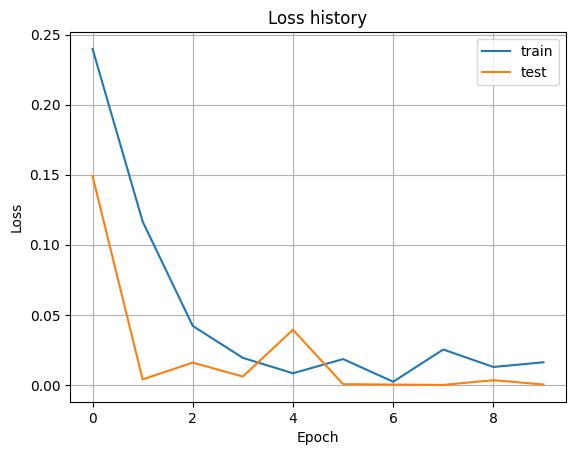

In [48]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();